# DELPHI simulations with FCChh impedance

Batch calculations working

1) Run X.Buffat script to compute the wanted impedance

2) Put the files in a scenario directory inside FCChh folder

3) Change the directory in this notebook and run it

### 1) Import libraries

In [1]:
%pylab notebook

import sys
import commands
from string import *
import time
import numpy as np
from copy import deepcopy
import os,re
from io_lib import *
from tables_lib import select_in_table
from particle_param import *
from Impedance import *
from DELPHI import *
from BSH_coll import FCChh_param
#The convergence is checked in these simulations



Populating the interactive namespace from numpy and matplotlib
('-f', '/afs/cern.ch/user/d/damorim/.local/share/jupyter/runtime/kernel-ef8d08b4-26ea-4b38-b7e5-686e01119795.json')


### 1bis) Creating the results directory

In [2]:
# machine parameters
machine2save='FCChh'; 

# CHANGE DIRECTORY HERE
# subdirectory (inside DELPHI_results/[machine2save]) where to put the results
ResultDir='/afs/cern.ch/work/d/damorim/work/DELPHI_results/FCChh/';

os.system("mkdir -p "+ResultDir);

### 2) Parameters

In [16]:
# beam parameters
e,m0,c,E0=proton_param();

E=3.3e12
V=12e6 #RF voltage

# E=50e12
# V=16e6 #RF voltage


# flags for plotting and DELPHI
flagdamperimp=0; # 1 to use frequency dependent damper gain (provided in Zd,fd)
strnorm=[''];
flagnorm=0; # 1 if damper matrix normalized at current chromaticity (instead of at zero chroma)
flagplot=True; # to write impedance files by elements
nevery=1; # downsampling of the impedance (take less points than in the full model)
wake_calc=False; # True -> compute wake as well (otherwise only imp.)


# number of eigenvalues ans convergence criterion for DELPHI
kmax=1; # number of converged eigenvalues (kmax most unstable ones are converged)
kmaxplot=300; # number of kept and plotted eigenvalues (in TMCI plot)
crit=5.0e-2
abseps=1.0e-4


# scan definition
scenarioscan=np.array(['BS_coll_3TeVV1']) #
Nbscan=np.arange(0,10.2e11,0.2e11); #C coll case

#scenarioscan=np.array(['BS_collMoGr_3TeVV1']) #
#Nbscan=np.arange(0,8.1e11,0.1e11); #MoGr coll case

#scenarioscan=np.array(['BS_only_3TeV_V1']) #
#Nbscan=np.arange(0,15.2e11,2e10); #BS only

#scenarioscan=np.array(['BS_collMoGr_interconnects_3TeVV6']) #
#Nbscan=np.arange(0,6.1e11,0.1e11); #MoGr coll case



print scenarioscan



Escan=np.array([3.3e12 for ii in scenarioscan]); # Energy at injection
subscan=np.arange(0,len(Escan))
print subscan


# setting the scans
planes=['x'];
Qpscan=np.arange(-20,20.5,0.5);
#Qpscan
dampscan=np.array([0.0,0.02,0.01]); # damper gain scan


Mscan=np.array([10600]); # scan on number of bunches
imp_fact=1. #impedance factor


# initialize impedance model and tune shifts
tuneshiftQp=np.zeros((len(subscan),2,len(Mscan),len(Qpscan),len(dampscan),len(Nbscan),1,1,kmaxplot),dtype=complex);
tuneshiftm0Qp=np.zeros((len(subscan),2,len(Mscan),len(Qpscan),len(dampscan),len(Nbscan),1,1),dtype=complex);

imp_mod_list=[]; # complete list of impedance scenarios
wake_mod_list=[];# complete list of wake scenarios

['BS_coll_3TeVV1']
[0]


In [17]:
for iscenario,scenario in enumerate(scenarioscan[subscan]):

    root_result=ResultDir+scenarioscan[subscan[iscenario]]+'/'
    os.system("mkdir -p "+root_result);

In [18]:
root_result

'/afs/cern.ch/work/d/damorim/work/DELPHI_results/FCChh/BS_coll_3TeVV1/'

In [19]:
if machine2save=='FCChh':
    machine_str,E,gamma,sigmaz,taub,R,Qx,Qxfrac,Qy,Qyfrac,Qs,eta,f0,omega0,omegas,dphase,Estr=FCChh_param(E=E,V=V)
    #machine=LHC(E0,E=Escan[subscan[iscenario]],scenario=model[subscan[iscenario]])

    g,a,b=longdistribution_decomp(taub,typelong="Gaussian");
    avbetax=R/Qx;avbetay=R/Qy; # average beta functions used
    print "scenario: ",scenario

3TeV
scenario:  BS_coll_3TeVV1


In [20]:
np.shape(tuneshiftQp)

(1, 2, 1, 81, 3, 51, 1, 1, 300)

In [21]:
len(Nbscan)

51

Data treatment

### 3) Retrieving the impedance

In [22]:
print 'Loading from impedance database...'+scenario
imp_mod=[]; wake_mod=[];
suffix='_FCChh_Allthemachine_'+Estr+'_halfgap_13mm.dat';
freq_mod,Z_mod=readZ(root_result+"Zxdip"+suffix);
Z_mod*=imp_fact

imp_mod.append(impedance_wake(a=1,b=0,c=0,d=0,plane='x',var=freq_mod,func=Z_mod));

#freq_mod,Z_mod=readZ(root_result+"Zydip"+suffix);
#Z_mod*=imp_fact


#imp_mod.append(impedance_wake(a=0,b=1,c=0,d=0,plane='y',var=freq_mod,func=Z_mod));

imp_mod_list.append(imp_mod);
wake_mod_list.append(wake_mod);

Loading from impedance database...BS_coll_3TeVV1


### 3bis) Impedance Plot

<IPython.core.display.Javascript object>


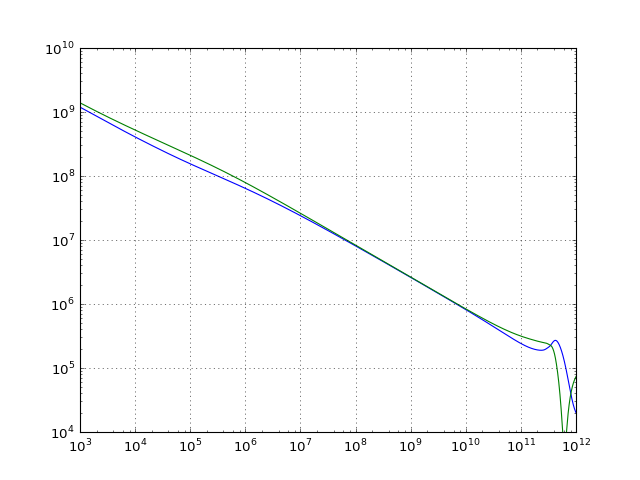

In [23]:
#Puting the impedance inside a list
Zlist_RW_R = deepcopy(imp_mod_list[0][0].func[::nevery,:])
freqlist_RW_R = deepcopy(imp_mod_list[0][0].var[::nevery])

#Impedance plot
plt.close('all')

plt.figure(1)
plt.loglog(freqlist_RW_R, Zlist_RW_R, '-')
plt.xlim([1.0e3,1.0e12])
plt.ylim([1.0e4,1.0e10])
plt.grid()

plt.show()

### 4) DELPHI calculations

In [11]:
# Retrieve DELPHI scans
root_result=ResultDir+scenario+'/ResultsFolder2';


for iscenario,scenario in enumerate(scenarioscan[subscan]):

    print 'DELPHI computation for '+scenario

    # DELPHI run
    tuneshiftQp[iscenario,:,:,:,:,:,:,:,:],tuneshiftm0Qp[iscenario,:,:,:,:,:,:,:]=DELPHI_wrapper(imp_mod_list[iscenario],Mscan,Qpscan,dampscan,Nbscan,[omegas],[dphase],omega0,Qx,Qy,gamma,eta,a,b,taub,g,planes,nevery=nevery,particle='proton',flagnorm=0,flagdamperimp=0,d=None,freqd=None,kmax=kmax,kmaxplot=kmaxplot,crit=crit,abseps=abseps,flagm0=True,lxplusbatch='retrieve',comment=machine_str+scenario+'_'+float_to_str(round(E/1e9))+'GeV_Z'+float_to_str(imp_fact),queue='2nw',dire=root_result+'/',flagQpscan_outside=True);

DELPHI computation for BS_coll_3TeVV1


In [12]:
tuneshiftm0Qp

array([[[[[[[[  0.00000000e+00 +0.00000000e+00j]],

            [[ -5.12697414e-05 -3.17453718e-05j]],

            [[ -1.02517568e-04 -6.34898834e-05j]],

            ..., 
            [[ -3.89782062e-04 -1.54805414e-06j]],

            [[ -3.97824859e-04 -2.10278499e-06j]],

            [[ -4.05862320e-04 -2.68601047e-06j]]],


           [[[  7.06830665e-19 -6.38864372e-20j]],

            [[ -8.32131475e-05 +1.76959216e-03j]],

            [[ -1.67137737e-04 +1.74308439e-03j]],

            ..., 
            [[ -5.29805609e-04 -3.79091677e-06j]],

            [[ -5.36625630e-04 -3.52578227e-06j]],

            [[ -5.43445482e-04 -3.39379742e-06j]]],


           [[[  5.62846691e-19 -1.30896376e-19j]],

            [[ -5.74488213e-05 +6.80530368e-04j]],

            [[ -1.13965187e-04 +6.52887118e-04j]],

            ..., 
            [[ -4.53850275e-04 +1.72639450e-05j]],

            [[ -4.61417960e-04 +1.64785249e-05j]],

            [[ -4.68992882e-04 +1.56508355e-05j]]]],



  

### 5) Write DELPHI output in files

In [13]:
''' Output file: data vs Qp '''

for iplane,plane in enumerate(planes):
    for iM,M in enumerate(Mscan):
        for idamp,damp in enumerate(dampscan):
            for Nb in Nbscan:
                strpart=['Re','Im'];
                for ir,r in enumerate(['real','imag']):
                    for iscenario,scenario in enumerate(scenarioscan[subscan]):

                        # output files name for data vs Qp
                        Estr=float_to_str(round(Escan[subscan[iscenario]]/1e9))+'GeV';
                        fileoutdataQp=root_result+'/data_vs_Qp_'+machine_str+'_'+Estr+scenario+'_'+str(M)+'b_d'+float_to_str(damp)+'_Nb'+float_to_str(Nb/1.e11)+'e11_'+str(kmax)+'converged'+strnorm[flagnorm]+'_'+plane;
                        fileoutdataQpm0=root_result+'/data_vs_Qp_m0_'+machine_str+'_'+Estr+scenario+'_'+str(M)+'b_d'+float_to_str(damp)+'_Nb'+float_to_str(Nb/1.e11)+'e11_'+str(kmax)+'converged'+strnorm[flagnorm]+'_'+plane;
                        fileoutdata_all=root_result+'/data_vs_Qp_all_'+machine_str+'_'+Estr+scenario+'_'+str(M)+'b_d'+float_to_str(damp)+'_Nb'+float_to_str(Nb/1.e11)+'e11_'+str(kmax)+'converged'+strnorm[flagnorm]+'_'+plane;

                        ts=getattr(tuneshiftQp[iscenario,iplane,iM,:,idamp,np.where(Nbscan==Nb),0,0,0],r);
                        data=np.hstack((Qpscan.reshape((-1,1)),ts.reshape((-1,1))));
                        write_ncol_file(fileoutdataQp+'_'+r+'.dat',data,header="Qp\t"+strpart[ir]+"_tuneshift")

                        tsm0=getattr(tuneshiftm0Qp[iscenario,iplane,iM,:,idamp,np.where(Nbscan==Nb),0,0],r);
                        data=np.hstack((Qpscan.reshape((-1,1)),ts.reshape((-1,1))));
                        write_ncol_file(fileoutdataQpm0+'_'+r+'.dat',data,header="Qp\t"+strpart[ir]+"_tuneshiftm0")

                        all_unstable_modes=getattr(tuneshiftQp[iscenario,iplane,iM,:,idamp,np.where(Nbscan==Nb),0,0,:],r);
                        data=np.hstack((Qpscan.reshape((-1,1)),all_unstable_modes.reshape((-1,kmaxplot))));
                        write_ncol_file(fileoutdata_all+'_'+r+'.dat',data,header="Qp\t"+strpart[ir]+"_tuneshift")



In [14]:
root_result

'/afs/cern.ch/work/d/damorim/work/DELPHI_results/FCChh/BS_coll_3TeVV1/ResultsFolder1'

In [15]:
np.save(root_result+'/tuneshiftQp_array.npy',tuneshiftQp)
np.save(root_result+'/tuneshiftm0Qp_array.npy',tuneshiftm0Qp)
